C:\Users\jagat\AppData\Local\Temp/ipykernel_22908/1392111612.py:27: RuntimeWarning: invalid value encountered in true_divide
  vector = vector / np.sqrt(np.sum(vector**2))


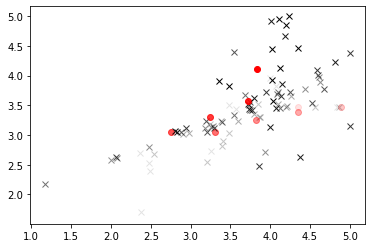

In [35]:
import numpy as np
class Agent:  
  dimensions = [3,2,4]
  topspeed = 1
  def __init__(self,position,hunger):
    self.position = np.array(position)
    self.hunger = hunger

class Prey(Agent):
  def move(self,agents):
    #randomly pick *another* Prey
    target = np.random.choice([a for a in agents if type(a)==Prey and a!=self])
    vector = target.position - self.position
    vector = vector / np.sqrt(np.sum(vector**2))
    self.position = self.position + vector * self.topspeed #+ (np.random.rand(2)-0.5)
    #keeps the Prey in a 5x5 box
    self.position[self.position<0] = 0
    self.position[self.position>5] = 5    

class Predator(Agent):
  topspeed = 0.55 
  def move(self,agents):
    vector = np.array([0,0])
    for a in agents:
      vector = a.position - self.position
      if (np.sum(vector**2)<3**2):
        vector = vector / np.sqrt(np.sum(vector**2))
    self.position = self.position + vector * self.topspeed
    #keeps the Predator in a 5x5 box
    self.position[self.position<0] = 0
    self.position[self.position>5] = 5    

agents = []
for i in range(1):
  agents.append(Predator(np.random.rand(2)*5,np.random.randint(10)))
for i in range(10):
  agents.append(Prey(np.random.rand(2)*5,5))  

#exercise 24
import matplotlib.pyplot as plt
%matplotlib inline
for it in range(10):
  for a in agents:
    a.move(agents)
  #plot there new positions
  for a in agents:
    if type(a)==Prey:
      plt.plot(a.position[0],a.position[1],'xk--',alpha=it/9)
    if type(a)==Predator:
      plt.plot(a.position[0],a.position[1],'or',alpha=it/9) 

In [48]:
a=[0,0]
a[0]=np.mean([a.position[0] for a in agents if type(a)==Prey])
a[1]=np.mean([a.position[1] for a in agents if type(a)==Prey])
a

[3.9923860400855133, 4.306043377542821]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Helper functions to calculate distances
def calcdistsqr(v):
    """Get euclidean distance^2 of v"""
    return np.sum(v**2)

def calcdist(v):
    """Get euclidean distance of v"""
    return np.sqrt(np.sum(v**2))


class Agent:
    """
    Base class for all types of agent
    """
    def __init__(self,position,age,food,speed,lastbreed):
        """
        age = age of agent in iterations
        food = how much food the agent has 'inside' (0=empty, 1=full)
        position = x,y position of the agent
        speed = how fast it can move (tiles/iteration)
        lastbreed = how long ago it last reproduced (iterations)
        """
        self.food = food
        self.age = age
        self.position = position
        self.speed = speed
        self.lastbreed = lastbreed
      
    def breed(self):
        """
        This will either return None, or a new agent object
        """
        new_agent = None
        if (self.lastbreed>self.breedfreq) and (self.food>self.breedfood):
            self.lastbreed = -1
            new_agent = type(self)(self.position,0,self.food/2,self.speed,10)
            self.food = self.food/2
        self.age+=1
        self.lastbreed+=1
        return new_agent
       
    def move(self,env):
        pass #to implement by child class
    
    def trymove(self,newposition,env):
        if env.check_position(newposition):
            self.position = newposition
        #ensures it's in the environment and rounds to nearest cell
        #env.fix_position(self.position)

    
    def eat(self,env,agents):
        pass #to implement by child class
    
    def summary_vector(self):
        """
        Returns a list of the location (x,y) and a 0=Predator, 1=Prey, e.g.
        [3,4,1] means a Prey at (3,4).
        """
        return [self.position[0],self.position[1],type(self)==Prey]
    
class Prey(Agent):
    
    #These are the same for all Preys.
    vision = 5 #how far it can see around current tile
    breedfreq = 10 #how many iterations have to elapse between reproduction events
    breedfood = 10 #how much food has to be eaten to allow reproduction
    maxage = 40 #how long do they live
    
    def __init__(self,position,age=None,food=10,speed=1,lastbreed=0):
        """
        A Prey agent. Arguments:
        age = age of agent in iterations (default is a random value between 0 and maxage)
        food = how much food the agent has 'inside' (0=empty, 1=full), default = 10
        position = x,y position of the agent (required)
        speed = how fast it can move (tiles/iteration) (default=1)
        lastbreed = how long ago it last reproduced (iterations) (default=0)
        """
        if age is None: age = np.random.randint(self.maxage)
        super().__init__(position,age,food,speed,lastbreed)
        self.eaten = False
        
    def move(self,env):
        """
        Prey movement:
         - if current cell has no food...
            - will move towards cells with more food
         - DOESN'T move away from nearby Predators
        """
        if env.get_food(self.position)==0:
            food_position = env.get_loc_of_grass(self.position,self.vision) #get the x,y location of nearby food (if any)
            if food_position is not None:
                relative_food_position = food_position - self.position
                if calcdistsqr(relative_food_position)<self.speed**2: #if distance to the food < how far we can go, then
                    self.trymove(food_position,env)

                else:
                    vect = relative_food_position / calcdist(relative_food_position)
                    self.trymove(self.position + vect * self.speed,env)
            else:
                #no food in range, pick a random direction...
                d = np.random.rand()*2*np.pi #pick a random direction
                delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)

                self.trymove(self.position + delta,env)
                        
    def eat(self,env,agents):
        """
         - will eat if there's food at location
         - otherwise food goes down by 1.
        """
        if env.get_food(self.position)>0:
            env.reduce_food(self.position)
            self.food += 1
        else:
            self.food -= 1
            
#    def draw(self):
#        plt.plot(self.position[0],self.position[1],'yx',mew=3)
        
    def die(self):
        """
        Returns true if it needs to expire, either due to:
         - no food left
         - old age
         - being eaten
        """
        if self.food<=0: return True
        if self.age>self.maxage: return True
        if self.eaten: return True
        return False
        
class Predator(Agent):

    #These are the same for all Predators.
    vision = 7 #how far it can see around current tile
    breedfreq = 30 #how many iterations have to elapse between reproduction events
    breedfood = 20 #how much food has to be eaten to allow reproduction
    maxage = 80 #how long do they live
    
    def __init__(self,position,age=None,food=10,speed=5,lastbreed=0):
        """
        A Predator agent. Arguments:
        age = age of agent in iterations (default is random age between 0 and maxage)
        food = how much food the agent has 'inside' (0=empty, 1=full) (default=10)
        position = x,y position of the agent (required)
        speed = how fast it can move (tiles/iteration) (default=5)
        lastbreed = how long ago it last reproduced (iterations) (default=0)
        """
        if age is None: age = np.random.randint(self.maxage)
        super().__init__(position,age,food,speed,lastbreed)    
    
    def get_nearby_Prey(self,position,vision,agents):
        """
        helper function, given the list of agents, find the nearest Prey, if within 'vision', else None.
        """
        #distances to dead Preys and Predators set to infinity.
        sqrdistances = np.sum((np.array([a.position if (type(a)==Prey) and (not a.die()) else np.array([-np.inf,-np.inf]) for a in agents])-position)**2,1)
        idx = np.argmin(sqrdistances)
        if sqrdistances[idx]<vision**2:
            return agents[idx]
        else:
            return None
    
    def eat(self,env,agents):
        """     
        Eat nearby Prey, with a probability that drops by distance
        """
        near_Prey = self.get_nearby_Prey(self.position,self.vision,agents) #get the x,y location of nearby Prey (if any)
        if near_Prey is not None:
            relative_food_position = near_Prey.position - self.position
            dist = calcdist(relative_food_position)
            if dist<self.speed: #if distance to the food < how far we can go, then
                # probability that Predator will kill Prey is ratio of speed to distance
                kill_prob = 1 - (dist / self.speed)
                if kill_prob>np.random.rand():
                    self.trymove(near_Prey.position,env)
                    near_Prey.eaten = True
                    self.food+=2#near_Prey.food/2

    def move(self,env):
        """
        Predators just move randomly (but also move during call to self.eat eating to catch Prey).
        """
        d = np.random.rand()*2*np.pi #pick a random direction
        delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)
        self.trymove(self.position + delta,env)
       
    def die(self):
        """
        Returns true if it needs to expire, due to either:
         - no food
         - old age
        """
        
        if self.food<=0: return True
        if self.age>self.maxage: return True
        return False